# HoVer-Net Inference Usage

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). We provide this notebook to show how the 'wsi' and 'roi' modes can be used and how to extract and utilise the generated results.  

First, ensure that the environment is set as, as instructed on the [README](https://github.com/simongraham/hovernet_inference/blob/master/README.md).

Modes available:
- 'wsi'
- 'tile'

'wsi' mode generates a npz file that contains a list of predicted nuclei centroids, types and masks. Each mask is cropped to prevent the file size being too large. When using this mode, the input must be a whole-slide image. Supported formats include those also supported by [OpenSlide](https://openslide.org/) and also jp2.

'tile' mode generates results in the form of a npy file and also generates an overlay of the results on top of the original image, where the colour of the boundary denotes the type of nucleus. When using this mode, the input must be in a standard image format, such as jpg or png.

The output of 'wsi' is a suitable format for enabling downstream analysis. If you require visualisation of results, then we recommend using 'roi' mode. If your input is a whole-slide image, then to use 'roi' mode, you must pre-extract image tiles from the whole-slide image.

In this notebook we will:

- Use a H&E image tile and process with 'tile' mode
- Use a H&E WSI and process with 'wsi' mode
- Pre-extract image tiles from a WSI and then process each tile with 'tile' mode


In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import math
import openslide as ops
import os

from hover.postproc import process_utils as proc_utils
from run import InferTile, InferWSI # import classes

In [2]:
# configuration that we won't chage throughout the notebook
args = {}

args['--gpu'] = '0'                  # GPU list
args['--model'] = 'pannuke.npz'     # Path to saved checkpoint.
args['--batch_size'] = 25            # Batch size
args['--tile_size'] = 10000          # Size of tiles (assumes square shape)
args['--return_masks'] = True        # Whether to return cropped nuclei masks

## Tile Processing Mode

In [3]:
# ROI mode

roi_input_dir = 'tile_input'
roi_output_dir = 'tile_output'

args['--mode'] = 'tile'                 # Inference mode. 'tile' or 'wsi'
args['--input_dir'] = tile_input_dir        # Directory containing input images/WSIs.
args['--output_dir'] = tile_output_dir      # Directory where the output will be saved

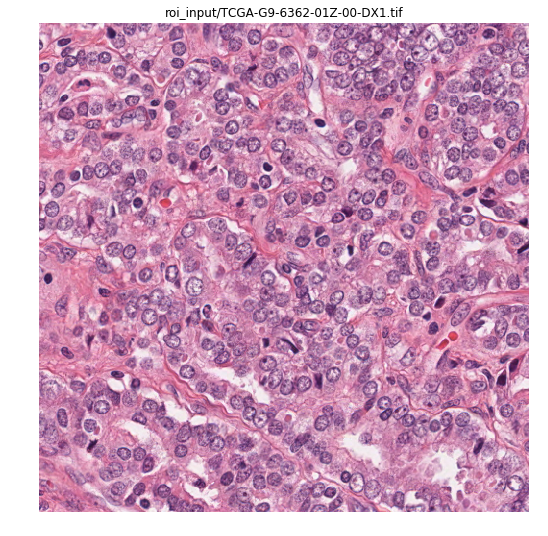

In [4]:
# View an image from the input directory

image_list = glob.glob(tile_input_dir + '/*') # get a list of the files in the directory
img = cv2.imread(image_list[0]) # read the first file
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads as BGR -> convert back to RGB

plt.figure(figsize=(9,9))
plt.imshow(img)
plt.axis('off')
plt.title(image_list[0])
plt.show()

In [5]:
# Initialise ROI mode and process all image tiles in the input folder

infer = InferTile()
infer.load_params(args)
infer.load_model() 
infer.process()

Loading Model...
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
roi_input TCGA-G9-6362-01Z-00-DX1 TCGA-G9-6362-01Z-00-DX1.tif


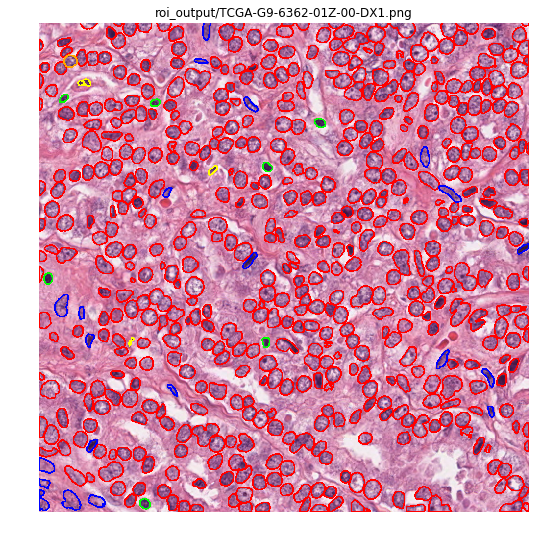

In [6]:
# Visualise the results 

# view overlaid results of the first image file 

overlay_list = glob.glob(roi_output_dir + '/*.png') # get a list of the overlaid results in the output directory
overlay = cv2.imread(overlay_list[0]) # read the first file
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB) # cv2 reads as BGR -> convert back to RGB

# red = neoplastic, orange = non-neoplastic epithelial, green = inflammatory, blue - connective, yellow = dead
plt.figure(figsize=(9,9))
plt.imshow(overlay)
plt.axis('off')
plt.title(overlay_list[0])
plt.show()

Shape: (1000, 1000, 2)


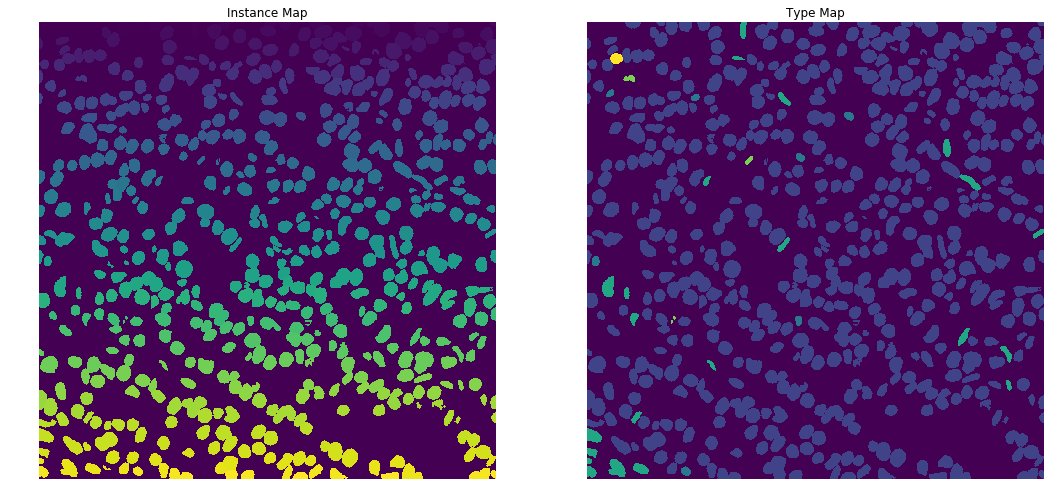

In [7]:
# view contents of numpy file

numpy_list = glob.glob(roi_output_dir + '/*.npy') # get a list of the numpy results in the output directory
numpy_file = np.load(numpy_list[0]) # read the first file

# the numpy file is a HxWx2 size array, where H and W are the height and width of the original image. 
# The first channel is the instance segmentation results and the second channel is the classification results.

print('Shape:', numpy_file.shape) # show the shape of the numpy file 

# Now let's plot each of the channels - 1st channel = instance map, 2nd channel = type map

inst_map = numpy_file[...,0]
type_map = numpy_file[...,1]


plt.figure(figsize=(18,15))

plt.subplot(1,2,1)
plt.imshow(inst_map)
plt.axis('off')
plt.title('Instance Map')

plt.subplot(1,2,2)
plt.imshow(type_map)
plt.axis('off')
plt.title('Type Map')

plt.show()

## WSI Processing Mode

In [8]:
# WSI mode

wsi_input_dir = 'wsi_input'
wsi_output_dir = 'wsi_output'

args['--mode'] = 'wsi'                 # Inference mode. 'roi' or 'wsi'
args['--input_dir'] = wsi_input_dir        # Directory containing input images/WSIs.
args['--output_dir'] = wsi_output_dir      # Directory where the output will be saved

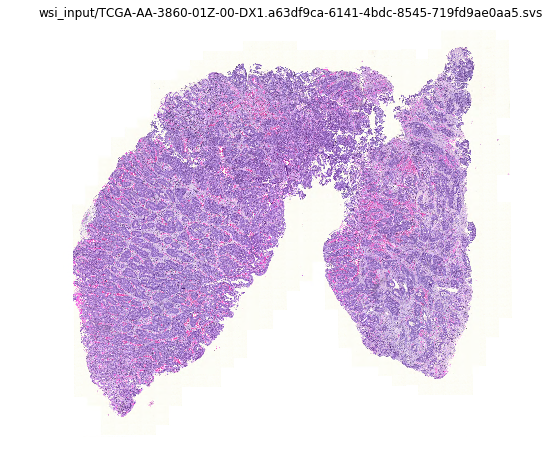

In [9]:
# View an WSI from the input directory using openslide library - image file must be supported

wsi_list = glob.glob(wsi_input_dir + '/*') # get a list of the files in the directory
wsi = ops.OpenSlide(wsi_list[0])
wsi_dims = wsi.level_dimensions
wsi_thumb = wsi.read_region((0,0), len(wsi_dims)-1, wsi_dims[-1]) # load the WSI at lowest available magnification

plt.figure(figsize=(9,9))
plt.imshow(wsi_thumb)
plt.axis('off')
plt.title(wsi_list[0])
plt.show()

In [10]:
# Initialise WSI mode and process all WSIs in the input folder

infer = InferWSI()
infer.load_params(args)
infer.load_model() 
infer.load_filenames()
infer.process_all_wsi() 

Loading Model...
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
/home/simon/Desktop/Projects/Nuclei_seg/hovernet_inference/wsi_input/TCGA-AA-3860-01Z-00-DX1.a63df9ca-6141-4bdc-8545-719fd9ae0aa5.svs
Batch (6/6) of Tile (6/6)5/6)

In [18]:
# Visualise the results

# wsi mode generates a npz file, containing a list of predicted centroid, types and masks. 
# Let's take a look at these

npz_list = glob.glob(wsi_output_dir + '/*') # get a list of the npz results in the output directory
npz_file = npz_list[0] # get the first file
npz_basename = os.path.basename(npz_file) # get the basename (used for reading wsi in next cell)
npz_file = np.load(npz_file + '/' + npz_basename + '.npz', allow_pickle=True) # load the npz file

centroid_list = npz_file['centroid'] # get the list of centroids
type_list = npz_file['type'] # get the list of predicted types
mask_list = npz_file['mask'] # get the list of cropped masks 

# verify that the number of elements in each list is the same- each element corresponds to a single nucleus
print('Centroid list:',len(centroid_list))
print('Type list:',len(type_list))
print('Mask list:',len(mask_list))

Centroid list: 206143
Type list: 206143
Mask list: 206143


In [25]:
# get the results for a randomly selected nucleus 

wsi_ext = '.svs' # file extension of wsi
wsi = ops.OpenSlide(wsi_input_dir + '/' + npz_basename + wsi_ext)
rand_nr = np.random.randint(len(centroid_list))

rand_centroid = centroid_list[rand_nr]
rand_type = type_list[rand_nr]
rand_mask = mask_list[rand_nr]

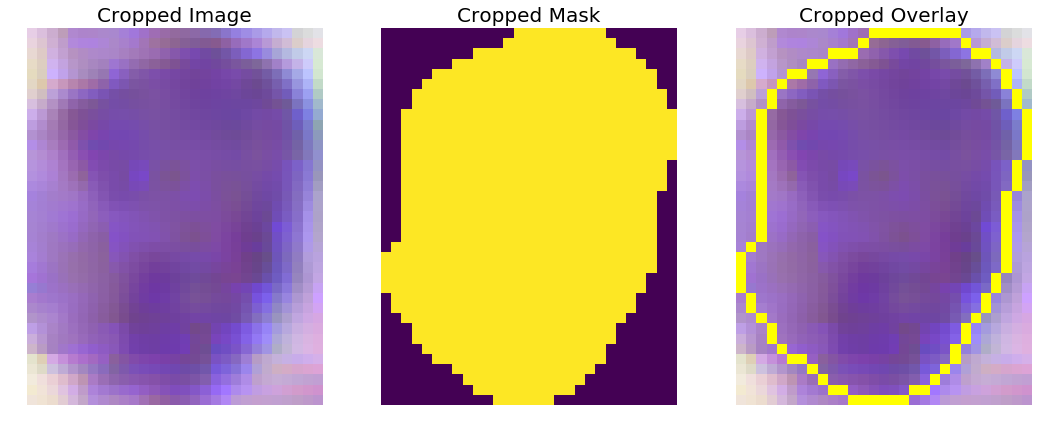

In [26]:
# visualise the cropped image, mask and overlay

rand_centroid = (int(round(rand_centroid[0])), int(round(rand_centroid[1])))
coords = (int(round(rand_centroid[1]-rand_mask.shape[1]/2)) , int(round(rand_centroid[0]-rand_mask.shape[0]/2)))

wsi_crop = wsi.read_region(coords, 0, (rand_mask.shape[1],rand_mask.shape[0]))
wsi_crop = np.array(wsi_crop)[...,:3]

# draw the overlay
cnt_crop = cv2.findContours(rand_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
overlay_crop = cv2.drawContours(wsi_crop.astype('uint8'), cnt_crop[0], -1, (255,255,0), 1)

# plot the images
plt.figure(figsize=(18,15))
plt.subplot(1,3,1)
plt.imshow(wsi_crop)
plt.title('Cropped Image', fontsize=20)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(rand_mask)
plt.title('Cropped Mask', fontsize=20)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(overlay_crop)
plt.title('Cropped Overlay', fontsize=20)
plt.axis('off')
plt.show()

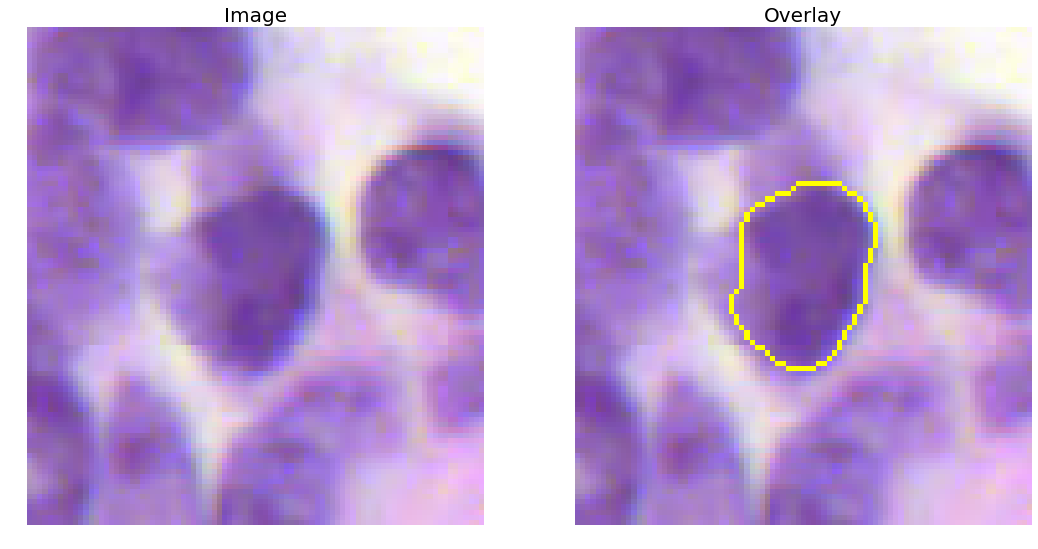

In [27]:
# visualise the cropped image, mask and overlay with additional context (control context wth pad)

pad = 30
coords2 = (int(round(rand_centroid[1]-rand_mask.shape[1]/2))-pad , int(round(rand_centroid[0]-rand_mask.shape[0]/2)-pad))
wsi_crop2 = wsi.read_region(coords2, 0, (rand_mask.shape[1]+2*pad,rand_mask.shape[0]+2*pad))
wsi_crop2 = np.array(wsi_crop2)[...,:3]

rand_mask2 =  np.lib.pad(rand_mask, ((pad, pad), (pad, pad)), 'constant')

# draw the overlay
cnt_crop2 = cv2.findContours(rand_mask2.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
overlay_crop2 = cv2.drawContours(wsi_crop2.astype('uint8'), cnt_crop2[0], -1, (255,255,0), 1)

# plot the images
plt.figure(figsize=(18,15))
plt.subplot(1,2,1)
plt.imshow(wsi_crop2)
plt.title('Image', fontsize=20)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay_crop2)
plt.title('Overlay', fontsize=20)
plt.axis('off')
plt.show()

## Extract Image Tiles from WSI

You may wish to use 'roi' mode for better visualisation. Therefore, we provide a class to pre-extract image tiles from a WSI that enables subsequent utilisation of 'roi' mode.

In [28]:
# function to extract tiles

class ExtractTiles(object):
    def __init__(self, wsipath, output_dir):
        self.wsipath = wsipath
        self.basename = os.path.basename(self.wsipath)
        self.basename = self.basename.split('.')[0]
        self.output_dir = output_dir
    
    def load_wsi(self):
        self.wsiobj = ops.OpenSlide(self.wsipath)
        self.level_dims =  self.wsiobj.level_dimensions
    
    def get_tissue_mask(self, tiss_lvl, proc_scale=0.25):
        self.tiss_lvl = tiss_lvl
        ds_wsi = self.wsiobj.read_region((0,0), self.tiss_lvl, self.level_dims[self.tiss_lvl])
        ds_wsi = np.array(ds_wsi)[...,:3]
        self.tissue = proc_utils.get_tissue_mask(ds_wsi, proc_scale)
    
    def extract_tiles(self, proc_lvl, tile_size):
        im_w = self.level_dims[proc_lvl][1]
        im_h = self.level_dims[proc_lvl][0]
        
        ds = self.wsiobj.level_downsamples[self.tiss_lvl] / self.wsiobj.level_downsamples[proc_lvl]

        nr_tiles_h = math.ceil(im_h / tile_size)
        nr_tiles_w = math.ceil(im_w / tile_size)

        step_h = tile_size
        step_w = tile_size

        for row in range(nr_tiles_h):
            for col in range(nr_tiles_w):
                start_h = row*step_h
                start_w = col*step_w
                if row == nr_tiles_h - 1:
                    extra_h = im_h - (nr_tiles_h * step_h)
                    dim_h = step_h + extra_h
                else:
                    dim_h = step_h
                if col == nr_tiles_w - 1:
                    extra_w = im_w - (nr_tiles_w * step_w)
                    dim_w = step_w + extra_w
                else:
                    dim_w = step_w
    
                image_tile = self.wsiobj.read_region((start_w, start_h), proc_lvl, (dim_w, dim_h))
                image_tile = np.array(image_tile)[...,:3]
                tissue_tile = self.tissue[int(round(start_h/ds)):int(round(start_h/ds))+int(round(dim_h/ds)), 
                                          int(round(start_w/ds)):int(round(start_w/ds))+int(round(dim_w/ds))]
                
                if np.mean(tissue_tile) > 0.1: # if tissue covers > 10% of tile, then save
                    plt.imsave(self.output_dir + '/' + basename + '%d_%d.png' %(row,col), image_tile)

In [ ]:
input_wsi = 'wsi.svs'       # place here path to wsi
output_dir = 'output_dir'   # place here path to output directory

tile_extractor = ExtractTiles(input_wsi, output_dir)
tile_extractor.load_wsi()
tile_extractor.get_tissue_mask(tiss_lvl=2)
tile_extractor.extract_tiles(proc_lvl=0, tile_size=10000)